# Concentrated Position Risk & Liquidity Analyzer



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration
YEARS_OF_DATA = 5
BENCHMARK = 'SPY'


In [2]:
# Get user inputs
ticker = input("Enter stock ticker (e.g., TSLA): ").strip().upper()
shares = float(input("Enter number of shares to hypothetically sell: "))
cost_basis = float(input("Enter average cost basis per share ($): "))
tax_rate = float(input("Enter tax rate as decimal (e.g., 0.20 for 20%): "))


In [3]:
# Calculate date range
end_date = datetime.now()
start_date = end_date - timedelta(days=YEARS_OF_DATA * 365)

print(f"\nFetching data for {ticker} and {BENCHMARK}...")

# Fetch stock data
stock = yf.Ticker(ticker)
stock_data = stock.history(start=start_date, end=end_date)

# Fetch benchmark data
benchmark = yf.Ticker(BENCHMARK)
benchmark_data = benchmark.history(start=start_date, end=end_date)

print(f" Data fetched successfully")
print(f"  {ticker}: {len(stock_data)} trading days")
print(f"  {BENCHMARK}: {len(benchmark_data)} trading days")





Fetching data for DIS and SPY...
 Data fetched successfully
  DIS: 1256 trading days
  SPY: 1256 trading days


In [4]:
## 4. Risk Analytics Engine

stock_prices = stock_data['Close']
benchmark_prices = benchmark_data['Close']

# Calculate daily returns
stock_returns = stock_prices.pct_change().dropna()
benchmark_returns = benchmark_prices.pct_change().dropna()

# Volatility 
volatility = stock_returns.std() * np.sqrt(252) 

# Beta 
aligned_returns = pd.DataFrame({
    'stock': stock_returns,
    'benchmark': benchmark_returns
}).dropna()

covariance = aligned_returns['stock'].cov(aligned_returns['benchmark'])
benchmark_variance = aligned_returns['benchmark'].var()
beta = covariance / benchmark_variance if benchmark_variance != 0 else 0.0

# Maximum DD 
running_max = stock_prices.expanding().max()
drawdown = (stock_prices - running_max) / running_max
max_drawdown = abs(drawdown.min())
max_drawdown_idx = drawdown.idxmin()

peak_price = running_max.loc[:max_drawdown_idx].max()
peak_date = running_max.loc[:max_drawdown_idx].idxmax()
trough_date = max_drawdown_idx

print("\nRisk Metrics Calculated:")
print(f"  Volatility: {volatility*100:.2f}%")
print(f"  Beta vs {BENCHMARK}: {beta:.2f}")
print(f"  Maximum Drawdown: {max_drawdown*100:.2f}%")
print(f"  Max Drawdown Period: {peak_date.strftime('%Y-%m-%d')} to {trough_date.strftime('%Y-%m-%d')}")



Risk Metrics Calculated:
  Volatility: 29.89%
  Beta vs SPY: 1.04
  Maximum Drawdown: 60.72%
  Max Drawdown Period: 2021-03-08 to 2023-10-04


## 5. Liquidity & Tax Simulation


In [5]:
current_price = stock_prices.iloc[-1]
proceeds = shares * current_price
total_cost_basis = shares * cost_basis
gain = proceeds - total_cost_basis
tax_estimate = gain * tax_rate if gain > 0 else 0
after_tax_proceeds = proceeds - tax_estimate

print("\nLiquidity & Tax Simulation:")
print(f"  Current Price: ${current_price:.2f}")
print(f"  Shares to Sell: {shares:,.0f}")
print(f"  Estimated Proceeds: ${proceeds:,.2f}")
print(f"  Total Cost Basis: ${total_cost_basis:,.2f}")
print(f"  Estimated Gain: ${gain:,.2f}")
print(f"  Tax Estimate ({tax_rate*100:.0f}%): ${tax_estimate:,.2f}")
print(f"  After-Tax Proceeds: ${after_tax_proceeds:,.2f}")



Liquidity & Tax Simulation:
  Current Price: $105.80
  Shares to Sell: 80
  Estimated Proceeds: $8,464.00
  Total Cost Basis: $6,400.00
  Estimated Gain: $2,064.00
  Tax Estimate (14%): $288.96
  After-Tax Proceeds: $8,175.04


In [6]:
## 6. Output Summary
print("\n" + "="*70)
print(f"CONCENTRATED POSITION ANALYSIS: {ticker}")
print("="*70)

print(f"\nCURRENT PRICE: ${current_price:.2f}")

print("\n" + "-"*70)
print("RISK METRICS")
print("-"*70)
print(f"  Volatility (Annualized):     {volatility*100:.2f}%")
print(f"  Beta vs. {BENCHMARK}:                {beta:.2f}")
print(f"  Maximum Drawdown:            {max_drawdown*100:.2f}%")
print(f"  Max Drawdown Period:         {peak_date.strftime('%Y-%m-%d')} to {trough_date.strftime('%Y-%m-%d')}")

print("\n" + "-"*70)
print("LIQUIDITY & TAX SIMULATION")
print("-"*70)
print(f"  Shares to Sell:              {shares:,.0f}")
print(f"  Estimated Proceeds:           ${proceeds:,.2f}")
print(f"  Total Cost Basis:            ${total_cost_basis:,.2f}")
print(f"  Estimated Gain:              ${gain:,.2f}")
print(f"  Tax Estimate:                ${tax_estimate:,.2f}")
print(f"  After-Tax Proceeds:          ${after_tax_proceeds:,.2f}")

print("\n" + "="*70)



CONCENTRATED POSITION ANALYSIS: DIS

CURRENT PRICE: $105.80

----------------------------------------------------------------------
RISK METRICS
----------------------------------------------------------------------
  Volatility (Annualized):     29.89%
  Beta vs. SPY:                1.04
  Maximum Drawdown:            60.72%
  Max Drawdown Period:         2021-03-08 to 2023-10-04

----------------------------------------------------------------------
LIQUIDITY & TAX SIMULATION
----------------------------------------------------------------------
  Shares to Sell:              80
  Estimated Proceeds:           $8,464.00
  Total Cost Basis:            $6,400.00
  Estimated Gain:              $2,064.00
  Tax Estimate:                $288.96
  After-Tax Proceeds:          $8,175.04



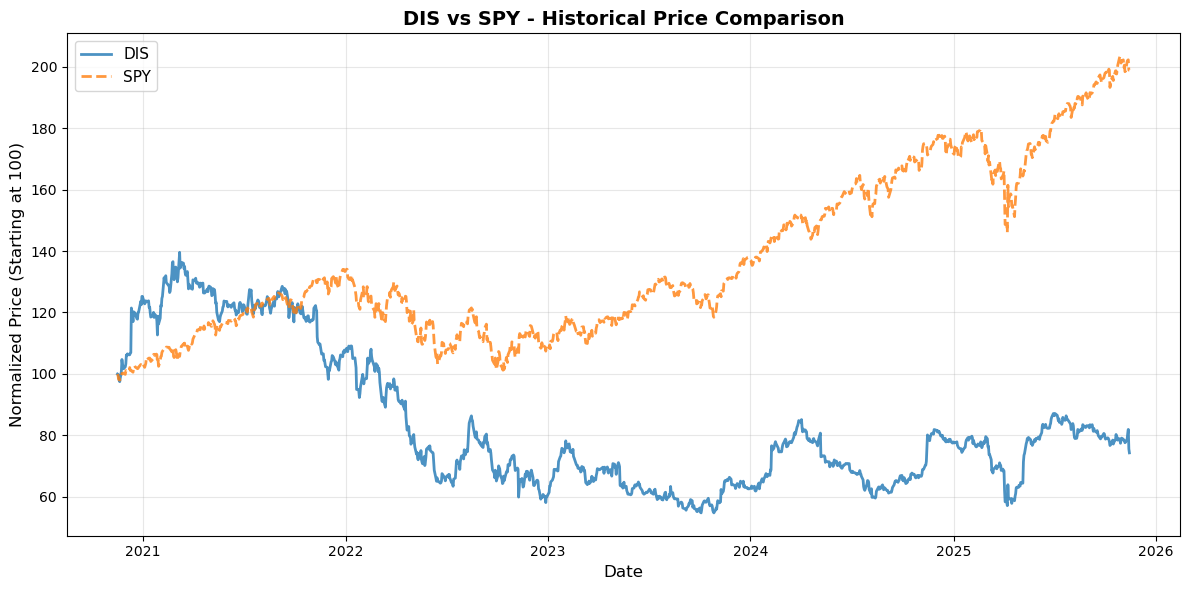

In [7]:
## 7. Visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Align dates
common_dates = stock_prices.index.intersection(benchmark_prices.index)
stock_aligned = stock_prices.loc[common_dates]
benchmark_aligned = benchmark_prices.loc[common_dates]

# Normalize to starting value of 100 for easier comparison
stock_normalized = (stock_aligned / stock_aligned.iloc[0]) * 100
benchmark_normalized = (benchmark_aligned / benchmark_aligned.iloc[0]) * 100

# Plot
ax.plot(stock_normalized.index, stock_normalized.values, 
        label=ticker, linewidth=2, alpha=0.8)
ax.plot(benchmark_normalized.index, benchmark_normalized.values, 
        label=BENCHMARK, linewidth=2, alpha=0.8, linestyle='--')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Price (Starting at 100)', fontsize=12)
ax.set_title(f'{ticker} vs {BENCHMARK} - Historical Price Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 8. Rolling Correlation & Additional Metrics


In [ ]:
# Calculate rolling correlation (60-day window)
window = 60
rolling_correlation = aligned_returns['stock'].rolling(window=window).corr(aligned_returns['benchmark'])

# Calculate rolling volatility (60-day window)
rolling_volatility = stock_returns.rolling(window=window).std() * np.sqrt(252)

# Calculate rolling beta (60-day window)
rolling_beta = pd.Series(index=aligned_returns.index, dtype=float)
for i in range(window, len(aligned_returns) + 1):
    window_data = aligned_returns.iloc[i-window:i]
    if len(window_data) >= window:
        cov = window_data['stock'].cov(window_data['benchmark'])
        var = window_data['benchmark'].var()
        if var != 0 and not pd.isna(cov):
            rolling_beta.iloc[i-1] = cov / var

# Calculate overall correlation
overall_correlation = aligned_returns['stock'].corr(aligned_returns['benchmark'])

# Calculate Sharpe Ratio (assuming risk-free rate of 0 for simplicity)
# Annualized Sharpe = (Mean Return / Std Dev) * sqrt(252)
mean_return = stock_returns.mean() * 252  # Annualized mean return
sharpe_ratio = mean_return / volatility if volatility > 0 else 0

# Calculate current correlation (last 30 days)
recent_correlation = aligned_returns.tail(30)['stock'].corr(aligned_returns.tail(30)['benchmark'])

print("\nAdditional Metrics:")
print(f"  Overall Correlation with {BENCHMARK}: {overall_correlation:.3f}")
print(f"  Recent Correlation (30-day): {recent_correlation:.3f}")
print(f"  Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
print(f"  Annualized Mean Return: {mean_return*100:.2f}%")


In [ ]:
# Create rolling correlation and metrics visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Rolling Correlation
axes[0].plot(rolling_correlation.index, rolling_correlation.values, 
             label=f'{ticker} vs {BENCHMARK} Rolling Correlation ({window}-day)', 
             linewidth=2, alpha=0.8, color='#2E86AB')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].axhline(y=overall_correlation, color='r', linestyle='--', alpha=0.5, 
                label=f'Overall Correlation: {overall_correlation:.3f}')
axes[0].set_ylabel('Correlation', fontsize=11)
axes[0].set_title(f'{ticker} - Rolling Correlation & Risk Metrics ({window}-Day Window)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-1, 1])

# Plot 2: Rolling Volatility
axes[1].plot(rolling_volatility.index, rolling_volatility.values * 100, 
             label=f'{ticker} Rolling Volatility ({window}-day)', 
             linewidth=2, alpha=0.8, color='#A23B72')
axes[1].axhline(y=volatility*100, color='r', linestyle='--', alpha=0.5, 
                label=f'Overall Volatility: {volatility*100:.2f}%')
axes[1].set_ylabel('Volatility (%)', fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling Beta
axes[2].plot(rolling_beta.index, rolling_beta.values, 
             label=f'{ticker} Rolling Beta vs {BENCHMARK} ({window}-day)', 
             linewidth=2, alpha=0.8, color='#F18F01')
axes[2].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Beta = 1.0 (Market)')
axes[2].axhline(y=beta, color='r', linestyle='--', alpha=0.5, label=f'Overall Beta: {beta:.2f}')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Beta', fontsize=11)
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Rolling metrics chart displayed above")


## 9. Additional Statistics & Insights


In [ ]:
# Calculate additional statistics
total_return = (stock_prices.iloc[-1] / stock_prices.iloc[0] - 1) * 100
benchmark_return = (benchmark_prices.iloc[-1] / benchmark_prices.iloc[0] - 1) * 100
excess_return = total_return - benchmark_return

# Calculate best and worst days
best_day_return = stock_returns.max() * 100
worst_day_return = stock_returns.min() * 100
best_day_date = stock_returns.idxmax()
worst_day_date = stock_returns.idxmin()

# Calculate positive vs negative days
positive_days = (stock_returns > 0).sum()
negative_days = (stock_returns < 0).sum()
win_rate = (positive_days / len(stock_returns)) * 100

# Calculate average daily return
avg_daily_return = stock_returns.mean() * 100

print("\n" + "="*70)
print("ADDITIONAL STATISTICS & INSIGHTS")
print("="*70)

print(f"\n📈 RETURN METRICS ({YEARS_OF_DATA} Years):")
print(f"  {ticker} Total Return: {total_return:.2f}%")
print(f"  {BENCHMARK} Total Return: {benchmark_return:.2f}%")
print(f"  Excess Return: {excess_return:.2f}%")
print(f"  Annualized Mean Return: {mean_return*100:.2f}%")
print(f"  Average Daily Return: {avg_daily_return:.3f}%")

print(f"\n📊 TRADING DAYS ANALYSIS:")
print(f"  Total Trading Days: {len(stock_returns):,}")
print(f"  Positive Days: {positive_days:,} ({win_rate:.1f}%)")
print(f"  Negative Days: {negative_days:,} ({100-win_rate:.1f}%)")

print(f"\n📉 EXTREME MOVES:")
print(f"  Best Day: {best_day_return:.2f}% on {best_day_date.strftime('%Y-%m-%d')}")
print(f"  Worst Day: {worst_day_return:.2f}% on {worst_day_date.strftime('%Y-%m-%d')}")

print(f"\n🔗 CORRELATION ANALYSIS:")
print(f"  Overall Correlation: {overall_correlation:.3f}")
print(f"  Recent Correlation (30-day): {recent_correlation:.3f}")
print(f"  Correlation Interpretation: ", end="")
if overall_correlation > 0.7:
    print("Highly correlated with market")
elif overall_correlation > 0.4:
    print("Moderately correlated with market")
elif overall_correlation > 0:
    print("Low positive correlation with market")
else:
    print("Negative correlation with market")

print(f"\n📊 RISK-ADJUSTED METRICS:")
print(f"  Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"  Volatility: {volatility*100:.2f}%")
print(f"  Beta: {beta:.2f}")

print("\n" + "="*70)
